In [1]:
import numpy as np
from scipy import misc as misc
import tensorflow as tf
from matplotlib import pyplot as plt

%matplotlib inline

In [4]:
tf.set_random_seed(777)
tmp = np.load('/data1/jerry/face/Network/data2.npz')
train_img = tmp['train_img']
train_lab = tmp['train_lab']

new = np.zeros([232,480,480,3])

new[:,128:352, 128:352, :] = train_img

print(train_img.shape)
print(train_lab.shape)
print(new.shape)

(232, 224, 224, 3)
(232, 2)
(232, 480, 480, 3)


In [2]:
tmp = np.load('/data1/jerry/face/Network/test_data.npz')
test_img = tmp['test_img']
test_lab = tmp['test_lab']
print(test_img.shape)
print(test_lab.shape)

(45, 224, 224, 3)
(45, 2)


In [5]:
num_classes = 2
X = tf.placeholder(tf.float32, shape=[None, 480,480,3])
Y = tf.placeholder(tf.float32, shape=[None, num_classes])
keep = tf.placeholder(tf.float32)

In [6]:
weights = {
    'wc1' : tf.get_variable('wc1', [7, 7, 3, 96], dtype=tf.float32, 
                            initializer=tf.contrib.layers.xavier_initializer()),    # 240
    'wc2' : tf.get_variable('wc2', [5, 5, 96, 256], dtype=tf.float32, 
                            initializer=tf.contrib.layers.xavier_initializer()),   # 120
    'wc3' : tf.get_variable('wc3', [3, 3, 256, 512], dtype=tf.float32, 
                            initializer=tf.contrib.layers.xavier_initializer()),   # 60
    'wc4' : tf.get_variable('wc4', [3, 3, 512, 512], dtype=tf.float32, 
                            initializer=tf.contrib.layers.xavier_initializer()),  # 30
    'wc5' : tf.get_variable('wc5', [3, 3, 512, 512], dtype=tf.float32, 
                            initializer=tf.contrib.layers.xavier_initializer()), # 15
    'wd1' : tf.get_variable('wd1', [14*14*512, 4048], dtype=tf.float32, 
                            initializer=tf.contrib.layers.xavier_initializer()),
    'wd2' : tf.get_variable('wd2', [4048, 4049], dtype=tf.float32, 
                            initializer=tf.contrib.layers.xavier_initializer()),
    'wd3' : tf.get_variable('wd3', [4049, num_classes], dtype=tf.float32, 
                            initializer=tf.contrib.layers.xavier_initializer())
}

biases = {
    'bc1' : tf.Variable(tf.zeros([96]), trainable=False, dtype=tf.float32),
    'bc2' : tf.Variable(tf.zeros([256]), trainable=False, dtype=tf.float32),
    'bc3' : tf.Variable(tf.zeros([512]), trainable=False, dtype=tf.float32),
    'bc4' : tf.Variable(tf.zeros([512]), trainable=False, dtype=tf.float32),
    'bc5' : tf.Variable(tf.zeros([512]), trainable=False, dtype=tf.float32),
    'bd1' : tf.Variable(tf.zeros([4048]), trainable=False, dtype=tf.float32),
    'bd2' : tf.Variable(tf.zeros([4049]), trainable=False, dtype=tf.float32),
    'bd3' : tf.Variable(tf.zeros([num_classes]), trainable=False, dtype=tf.float32)
}

In [7]:
def model(x, w, b, k):
    
    with tf.device('/gpu:1'):
        # 480 x 480
        conv1 = tf.nn.conv2d(x, w['wc1'], strides=[1, 1, 1, 1], padding='SAME')
        act1 = tf.nn.relu(conv1 + b['bc1'])
        pool1 = tf.nn.max_pool(act1, ksize=[1, 3, 3, 1], strides=[1, 3, 3, 1], padding='SAME')
    
        # 160 x 160
        conv2 = tf.nn.conv2d(pool1, w['wc2'], strides=[1, 1, 1, 1], padding='SAME')
        act2 = tf.nn.relu(conv2 + b['bc2'])
        pool2 = tf.nn.max_pool(act2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
        # 80 x 80
        conv3 = tf.nn.conv2d(pool2, w['wc3'], strides=[1, 1, 1, 1], padding='SAME')
        act3 = tf.nn.relu(conv3 + b['bc3'])
        pool3 = tf.nn.max_pool(act3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
    
        # 40 x 40
        conv4 = tf.nn.conv2d(pool3, w['wc4'], strides=[1, 1, 1, 1], padding='SAME')
        act4 = tf.nn.relu(conv4 + b['bc4'])
    
    with tf.device('/gpu:1'):
        # 40 x 40
        conv5 = tf.nn.conv2d(act4, w['wc5'], strides=[1, 1, 1, 1], padding='SAME')
        act5 = tf.nn.relu(conv5 + b['bc5'])
        pool5 = tf.nn.max_pool(act5, ksize=[1, 3, 3, 1], strides=[1, 3, 3, 1], padding='SAME')
        #print(pool5)
    
    
        #print(pool5.shape)
        flat = tf.reshape(pool5, [-1, 14*14*512])
    
        act6 = tf.nn.relu(tf.matmul(flat, w['wd1'])+b['bd1'])
        drop1 = tf.nn.dropout(act6, keep_prob=k)
    
        act7 = tf.nn.relu(tf.matmul(drop1, w['wd2'])+b['bd2'])
        drop2 = tf.nn.dropout(act7, keep_prob=k)
    
        output = tf.matmul(drop2, w['wd3'])+b['bd3']
    
    out = {
        'act1':act1,
        'act2':act2,
        'act3':act3,
        'act4':act4,
        'act5':act5,
        'act6':act6,
        'act7':act7,
        'output':output
        
    }
    
    
    return out
    

In [8]:
pred = model(X, weights, biases, keep)

In [9]:
cost= tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred['output'], labels=Y))

train = tf.train.AdamOptimizer(0.001).minimize(cost)

collect = tf.equal(tf.argmax(pred['output'], axis=1), tf.argmax(Y, axis=1))

accuracy = tf.reduce_mean(tf.cast(collect, tf.float32))

In [10]:
sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True)))
#sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.restore(sess, './checkpoint/')

INFO:tensorflow:Restoring parameters from ./checkpoint/


In [11]:
def infer(x):
    softmax = tf.nn.softmax(pred['output'])
    return sess.run(softmax, feed_dict={X:x, keep:1.0})

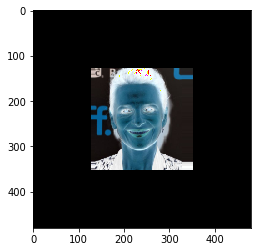

[[ 0.3888061  0.6111939]]


In [12]:
num = 100
plt.imshow(new[num,:,:,:])
plt.show()

print(infer(np.reshape(new[num,:,:,:], [1, 480, 480,3])))

In [20]:
test_img2 = None
for i, img in enumerate(test_img):
    #print(img.shape)
    tmp = misc.imresize(img, [480,480,3])
    tmp = np.reshape(tmp, [1, 480, 480, 3])
    if i==0:
        test_img2 = tmp
    else:
        test_img2 = np.concatenate((test_img2, tmp), axis=0)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


In [22]:
test_img3 = np.zeros([45,480,480,3])
test_img3[:,128:352,128:352,:] = test_img

Test 1's accuracy :  0.529412
Test 2's accuracy :  0.705882


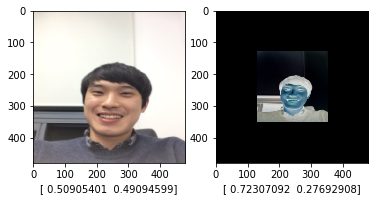

[ 0.  1.]


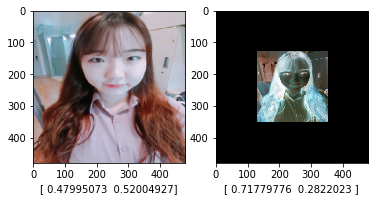

[ 1.  0.]


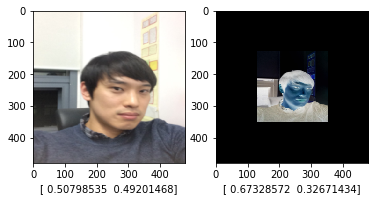

[ 1.  0.]


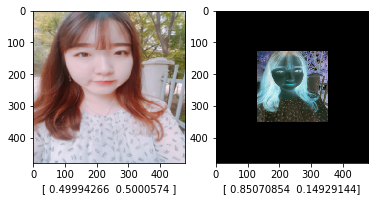

[ 1.  0.]


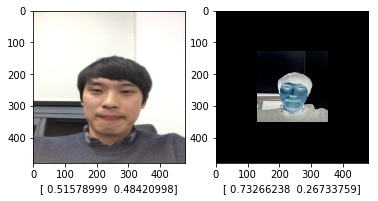

[ 0.  1.]


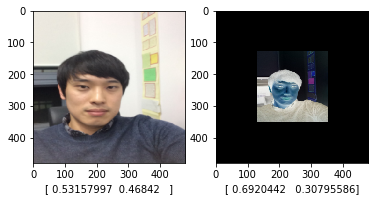

[ 1.  0.]


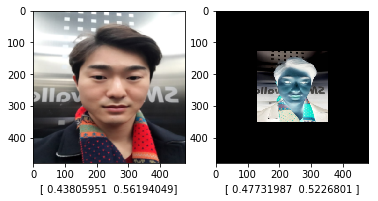

[ 1.  0.]


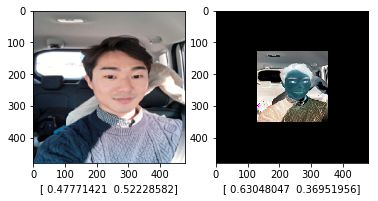

[ 1.  0.]


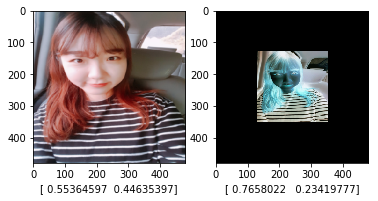

[ 0.  1.]


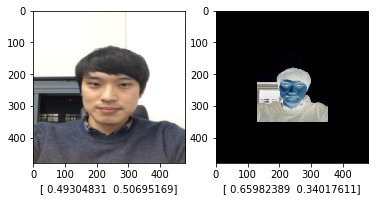

[ 1.  0.]


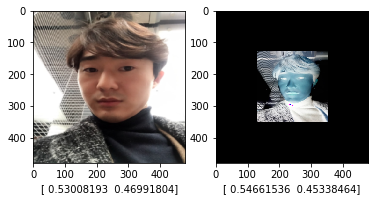

[ 1.  0.]


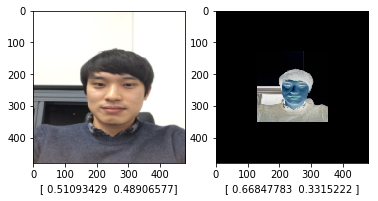

[ 1.  0.]


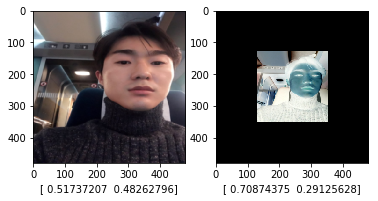

[ 1.  0.]


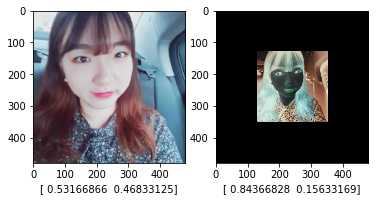

[ 1.  0.]


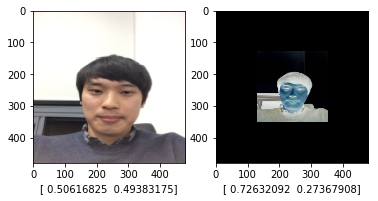

[ 1.  0.]


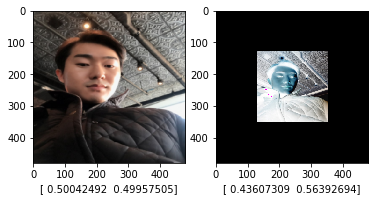

[ 1.  0.]


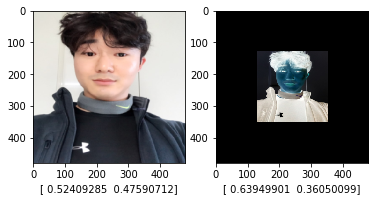

[ 1.  0.]


In [40]:
rand_idx = np.random.choice(45, 17, replace=False)
print("Test 1's accuracy : ", sess.run(accuracy, feed_dict={X:test_img2[rand_idx], Y:test_lab[rand_idx], keep:1.0}))
print("Test 2's accuracy : ", sess.run(accuracy, feed_dict={X:test_img3[rand_idx], Y:test_lab[rand_idx], keep:1.0}))      

Test1 = infer(test_img2[rand_idx])
Test2 = infer(test_img3[rand_idx])

for idx, i in enumerate(rand_idx):
    plt.subplot(121)
    plt.imshow(test_img2[i])
    plt.xlabel(Test1[idx])
    
    plt.subplot(122)
    plt.imshow(test_img3[i])
    plt.xlabel(Test2[idx])
    plt.show()
    
    print(test_lab[i])